In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tdse.evol import get_D2_tridiag, get_M2_tridiag, mul_tridiag_and_diag

from tdse.matrix_py import mat_vec_mul_tridiag, gaussian_elimination_tridiagonal

def tridiag_forward(tridiag, v, b):
    b[:] = mat_vec_mul_tridiag(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], v)

def tridiag_backward(tridiag, v, b):
    v[:] = gaussian_elimination_tridiagonal(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], b)

In [2]:
x_arr = np.linspace(-50,50,501)
delta_x = x_arr[1] - x_arr[0]
N_x = x_arr.size

In [3]:
D2 = get_D2_tridiag(N_x, delta_x)
M2 = get_M2_tridiag(N_x)
V_x_arr = np.zeros_like(x_arr, dtype=float)
M2V = mul_tridiag_and_diag(M2, V_x_arr)

In [4]:
sf_arr = np.empty_like(x_arr, dtype=complex)
from tdse.analytic import Gaussian1D
k_x = 0.0
sf_arr[:] = Gaussian1D(x_arr, t=0.0, k_x=k_x)

# [TODO] Check whether the W_root_plus and W_root_minus have same effect 

In [19]:
winop_n=1
gamma = 0.1
E_min = -5.0
N_E = 50
E_arr = E_min + 2*gamma*np.arange(N_E)
spectrum_E_arr = np.empty_like(E_arr, dtype=float)

winop_left_tridiag_static = -0.5*D2 + M2V + (1.0j*gamma)*M2
right_arr = np.empty_like(x_arr, dtype=complex)
root_W_sf_arr = np.empty_like(x_arr, dtype=complex)

norm_const = np.sin(np.pi/2**winop_n) / (np.pi/2**winop_n)

from tdse.integral import eval_norm_trapezoid

for E_idx, E0 in enumerate(E_arr):
    
    winop_left_tridiag = winop_left_tridiag_static - E0 * M2
    tridiag_forward(gamma*M2, sf_arr, right_arr)
    tridiag_backward(winop_left_tridiag, root_W_sf_arr, right_arr)

    spectrum_E_arr[E_idx] = 1.0 / (2.0*gamma) * norm_const * eval_norm_trapezoid(x_arr, root_W_sf_arr)

# Comparison to analytical result

In [20]:
pos_E_arr = E_arr[E_arr > 0]
pos_k_arr = np.sqrt(2.0*pos_E_arr)
from tdse.analytic import Gaussian1D_k_t0
spectrum_E_ana_arr = 1.0/pos_k_arr * (
    np.square( np.abs(Gaussian1D_k_t0(pos_k_arr, k_x)) ) 
    + np.square( np.abs(Gaussian1D_k_t0(-pos_k_arr, k_x)) )
)

## Draw

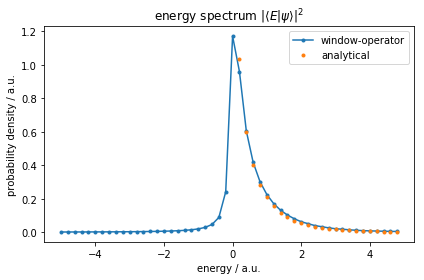

In [39]:
figE, axE = plt.subplots()
li_winop, = axE.plot(E_arr, spectrum_E_arr, '.-')
li_ana, = axE.plot(pos_E_arr, spectrum_E_ana_arr, '.')

axE.set_title(r"energy spectrum $|{\langle}E|\psi{\rangle}|^2$")
axE.set_xlabel("energy / a.u.")
axE.set_ylabel("probability density / a.u.")
axE.legend((li_winop, li_ana), ("window-operator", "analytical"))

figE.tight_layout()

In [36]:
# figE.savefig("winop-analytical-comparison-test.png")

In [9]:
from tdse.integral import numerical_integral_trapezoidal

In [10]:
numerical_integral_trapezoidal(pos_E_arr, spectrum_E_ana_arr)

0.5366504241584602

---

In [26]:
pos_E_arr = E_arr[E_arr > 0]
pos_k_arr = np.sqrt(2.0 * pos_E_arr)

k_arr = np.empty((pos_k_arr.size * 2 + 1,))
k_arr[:pos_k_arr.size] = -np.flip(pos_k_arr)
k_arr[pos_k_arr.size] = 0
k_arr[pos_k_arr.size+1:] = pos_k_arr

# E_arr[E_arr >= 0]

In [28]:
from tdse.analytic import Gaussian1D_k_t0

spectrum_k_arr = Gaussian1D_k_t0(k_arr, k_x)

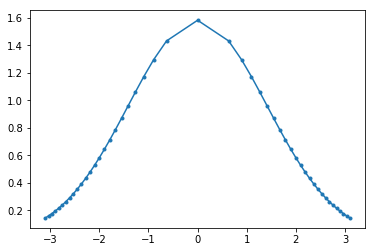

In [29]:
figk, axk = plt.subplots()
axk.plot(k_arr, spectrum_k_arr, '.-')